In [2]:
from sktime.performance_metrics.forecasting import MeanAbsoluteScaledError
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import TimeSeriesSplit
import pandas as pd
import numpy as np
import datetime
import requests
import warnings

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates

from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import OrdinalEncoder

from sklearn.model_selection import train_test_split
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import StandardScaler

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer

# Import Data

In [36]:
original = pd.read_csv('new_dataset/owid-covid-data-most-recent.csv')

df = pd.read_csv('multivariate.csv')
df['date'] = pd.to_datetime(df['date'])
df = df[df['date'] < '2024-01-14']
df = df.sort_values(by='date')

# impute missing values
# when total_cases is nan, set is to 0 
df['total_cases'] = df['total_cases'].fillna(0)
df['new_cases'] = df['new_cases'].fillna(0)
df['total_cases_per_million'] = df['total_cases_per_million'].fillna(0)
df['new_cases_per_million'] = df['new_cases_per_million'].fillna(0)
df = df.drop(columns = ['weekly_icu_admissions_per_million'], axis = 1, errors = 'ignore')
vaccine_columns = [col for col in df.columns if 'vaccin' in col]
# for the dates before december 11 2020, for the rows where the vaccine columns are nan, set them to very high outlier
df.loc[df['date'] < '2020-12-13', vaccine_columns] = df.loc[df['date'] < '2020-12-13', vaccine_columns].fillna(111000000)
df = df.set_index('date')
df = df.dropna(subset=['new_deaths'])
df = pd.get_dummies(df)

train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

X_train = train.drop(columns=['new_deaths'])
y_train = train['new_deaths']
X_test = test.drop(columns=['new_deaths'])
y_test = test['new_deaths']

mase = MeanAbsoluteScaledError(sp=13)

In [122]:

#K-fold cross validation to find optimal parameters for XGBoost
param_grid = {'max_depth': [4,8],
              'learning_rate': [0.01, 0.1, .3, .4],
               'reg_lambda':[0, 5, 10],
                'n_estimators':[100, 500, 1000],
                'gamma': [0, 10, 100]}

cv = TimeSeriesSplit(n_splits=4)
optimal_params = RandomizedSearchCV(estimator=xgb.XGBRegressor(random_state=1),                                                       
                             param_distributions = param_grid, n_iter = 50,
                             verbose = 2,
                             n_jobs=-1,
                             cv = cv,
                             scoring = 'neg_mean_absolute_error',
                             return_train_score=True,
                             )
optimal_params.fit(X_train,y_train)
print("Optimal parameter values =", optimal_params.best_params_)
print("Optimal cross MAE = ",optimal_params.best_score_)

#Train XGBoost model with optimal parameters
model = xgb.XGBRegressor(max_depth=optimal_params.best_params_['max_depth'],
                        learning_rate=optimal_params.best_params_['learning_rate'],
                        reg_lambda=optimal_params.best_params_['reg_lambda'],
                        n_estimators=optimal_params.best_params_['n_estimators'],
                        gamma=optimal_params.best_params_['gamma'],
                        random_state=1,
                        early_stopping_rounds=100)
model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='mae'
         )

Fitting 4 folds for each of 50 candidates, totalling 200 fits
[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10; total time=   0.8s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=0; total time=   3.4s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10; total time=   1.7s
[CV] END gamma=10, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=10; total time=   1.6s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=0; total time=   1.7s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10; total time=   2.4s
[CV] END gamma=10, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=10; total time=   3.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=4, n_estimators=100, reg_lambda=10; total time=   3.1s
[CV] END gamma=0, learning_rate=0.1, max_depth=8, n_estimators=100, reg_lambda=0; total time=   5.3s
[CV] END gamma=10, le

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=100,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=1, ...)

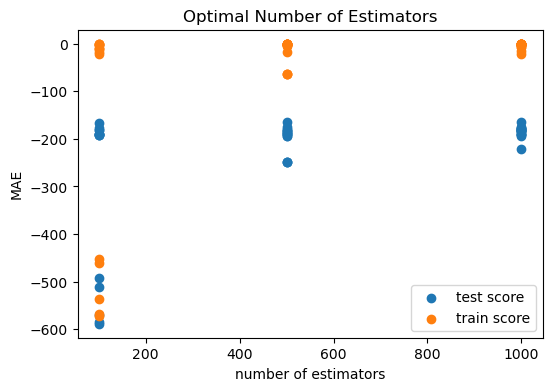

In [123]:
# visualize performance on the parameters grid
cv_results = pd.DataFrame(optimal_params.cv_results_)

plt.figure(figsize=(6,4))
plt.scatter(cv_results["param_n_estimators"], cv_results["mean_test_score"])
plt.scatter(cv_results["param_n_estimators"], cv_results["mean_train_score"])
plt.xlabel('number of estimators')
plt.ylabel('MAE')
plt.title("Optimal Number of Estimators")
plt.legend(['test score', 'train score'], loc='lower right')


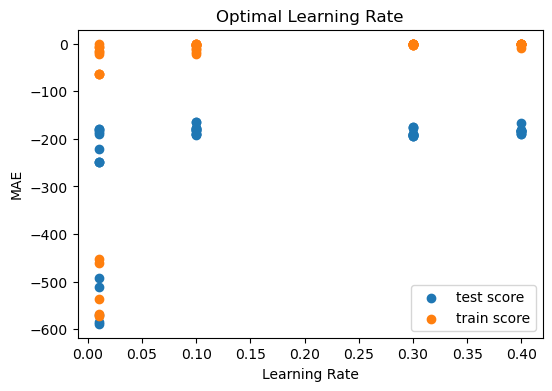

In [124]:
plt.figure(figsize=(6,4))
plt.scatter(cv_results["param_learning_rate"], cv_results["mean_test_score"])
plt.scatter(cv_results["param_learning_rate"], cv_results["mean_train_score"])
plt.xlabel('Learning Rate')
plt.ylabel('MAE')
plt.title("Optimal Learning Rate")
plt.legend(['test score', 'train score'], loc='lower right')



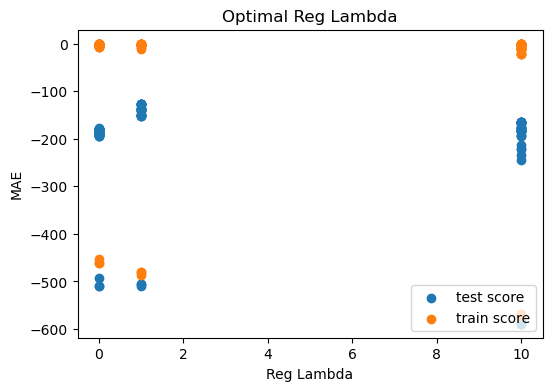

In [119]:
plt.figure(figsize=(6,4))
plt.scatter(cv_results["param_reg_lambda"], cv_results["mean_test_score"])
plt.scatter(cv_results["param_reg_lambda"], cv_results["mean_train_score"])
plt.xlabel('Reg Lambda')
plt.ylabel('MAE')
plt.title("Optimal Reg Lambda")
plt.legend(['test score', 'train score'], loc='lower right')



In [61]:
model = xgb.XGBRegressor(max_depth=optimal_params.best_params_['max_depth'],
                        learning_rate=optimal_params.best_params_['learning_rate'],
                        reg_lambda=optimal_params.best_params_['reg_lambda'],
                        n_estimators=optimal_params.best_params_['n_estimators'],
                        gamma=optimal_params.best_params_['gamma'],
                        subsample=optimal_params.best_params_['subsample'],
                        colsample_bytree=optimal_params.best_params_['colsample_bytree'],
                        random_state=1,
                        early_stopping_rounds=100,
                        eval_metric='mae')
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 45)

model.fit(X_train, y_train,
        eval_set=[(X_train_sub,y_train_sub),(X_test_sub, y_test_sub)],
        verbose=True)

results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mae"], label="Training error")
plt.plot(results["validation_1"]["mae"], label="Validation error")
plt.axvline(model.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Loss")
plt.legend()
# test['Prediction'] = model.predict(X_test)
# deaths = pd.concat([test, train], sort=False)
# _ = deaths[['new_deaths','Prediction']].plot(figsize=(15, 5))

NameError: name 'optimal_params' is not defined

[0]	validation_0-mae:828.30633	validation_1-mae:782.02499
[1]	validation_0-mae:628.42906	validation_1-mae:594.79415
[2]	validation_0-mae:479.29892	validation_1-mae:446.53518
[3]	validation_0-mae:364.51045	validation_1-mae:340.53790


[4]	validation_0-mae:278.49082	validation_1-mae:260.31934
[5]	validation_0-mae:213.22485	validation_1-mae:198.46478
[6]	validation_0-mae:163.56418	validation_1-mae:152.13179
[7]	validation_0-mae:125.45499	validation_1-mae:116.14805
[8]	validation_0-mae:96.69773	validation_1-mae:89.56477
[9]	validation_0-mae:74.89204	validation_1-mae:68.61900
[10]	validation_0-mae:58.73013	validation_1-mae:51.99593
[11]	validation_0-mae:46.37835	validation_1-mae:40.15493
[12]	validation_0-mae:37.10388	validation_1-mae:31.51409
[13]	validation_0-mae:29.69416	validation_1-mae:25.52458
[14]	validation_0-mae:24.43372	validation_1-mae:20.32670
[15]	validation_0-mae:20.63339	validation_1-mae:17.14138
[16]	validation_0-mae:17.64202	validation_1-mae:14.98275
[17]	validation_0-mae:15.53190	validation_1-mae:13.02633
[18]	validation_0-mae:13.89776	validation_1-mae:11.20310
[19]	validation_0-mae:12.47296	validation_1-mae:10.06965
[20]	validation_0-mae:11.32145	validation_1-mae:9.15020
[21]	validation_0-mae:10.38512

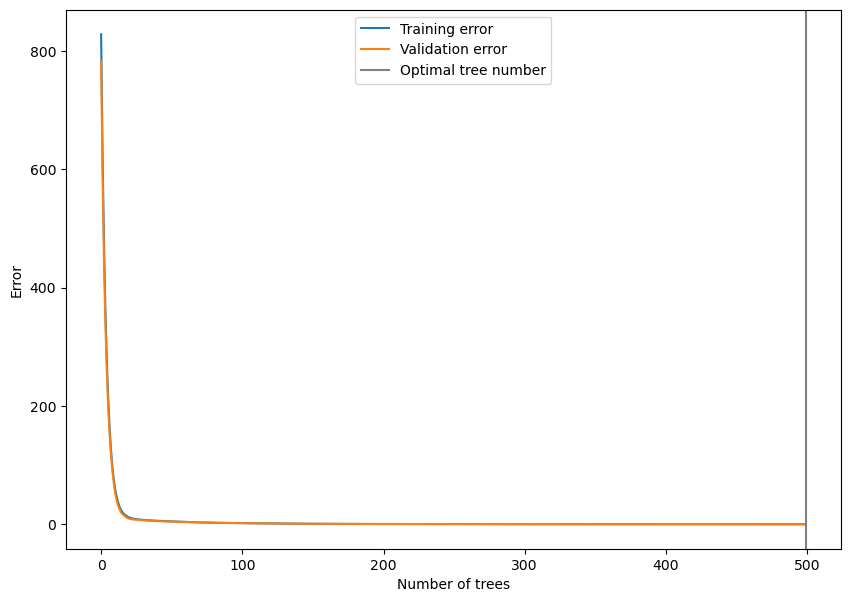

In [4]:
model = xgb.XGBRegressor(learning_rate=0.25, n_estimators=500, early_stopping_rounds=15)
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 45)

model.fit(X_train, y_train,
        eval_set=[(X_train_sub,y_train_sub),(X_test_sub, y_test_sub)],
        verbose=True,
        eval_metric='mae')
results = model.evals_result()
plt.figure(figsize=(10,7))
plt.plot(results["validation_0"]["mae"], label="Training error")
plt.plot(results["validation_1"]["mae"], label="Validation error")
plt.axvline(model.best_iteration, color="gray", label="Optimal tree number")
plt.xlabel("Number of trees")
plt.ylabel("Error")
plt.legend()


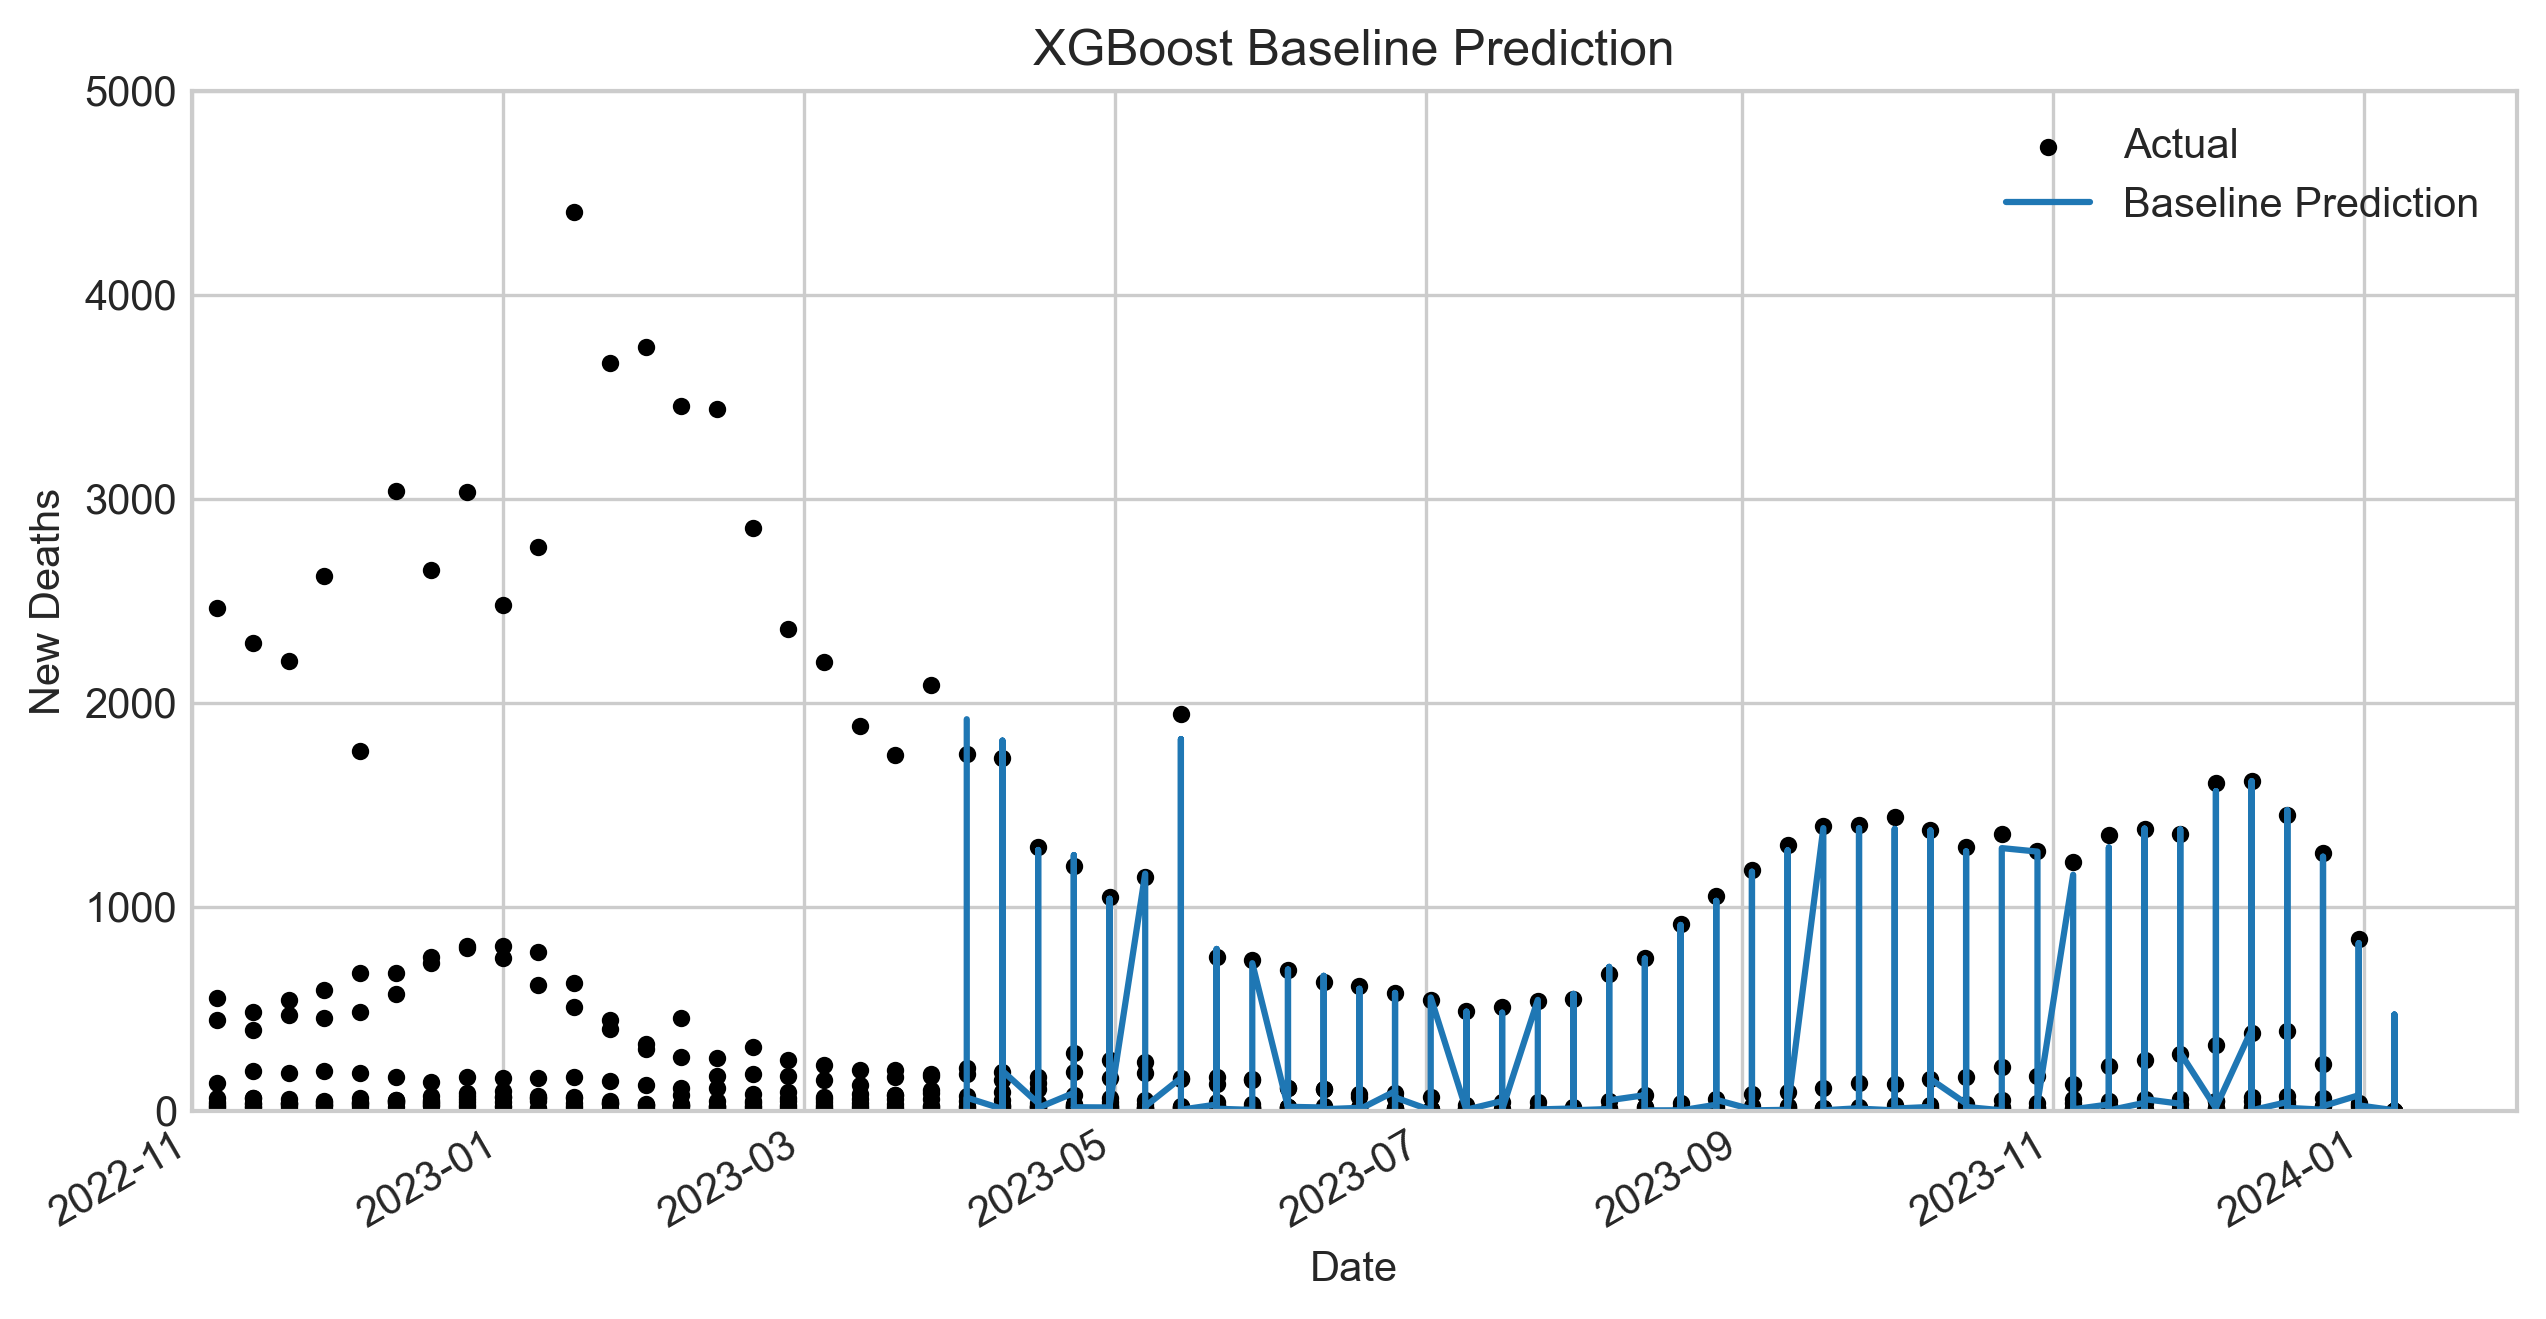

In [60]:
# baseline model
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
test['Baseline Prediction'] = model.predict(X_test)
deaths = pd.concat([test, train], sort=False)
# matplotlib line plot
# reset style
plt.style.use('seaborn-v0_8-whitegrid')
# increase resolution
plt.figure(dpi=300)
plt.scatter(deaths.index, deaths['new_deaths'], label='Actual', color = 'black', s=10)
plt.plot(deaths['Baseline Prediction'], label='Baseline Prediction')
plt.legend()
# make plot from november 2022
plt.xlim([datetime.date(2022, 11, 1), datetime.date(2024, 1, 31)])
plt.ylabel('New Deaths')
plt.xlabel('Date')
plt.title('XGBoost Baseline Prediction')
plt.gcf().autofmt_xdate()
fig = plt.gcf()
fig.set_size_inches(10, 5)
# limit max of y axis 
plt.ylim(0, 5000)
# change style of plot to ggplot
plt.show()


[0]	validation_0-mae:715.09106	validation_1-mae:805.44049
[1]	validation_0-mae:506.64241	validation_1-mae:578.68592
[2]	validation_0-mae:361.53039	validation_1-mae:408.32423
[3]	validation_0-mae:258.23723	validation_1-mae:291.90454
[4]	validation_0-mae:183.91753	validation_1-mae:211.39145
[5]	validation_0-mae:132.15492	validation_1-mae:150.73007
[6]	validation_0-mae:94.31901	validation_1-mae:110.47392
[7]	validation_0-mae:68.40637	validation_1-mae:80.43401
[8]	validation_0-mae:49.73517	validation_1-mae:59.18104
[9]	validation_0-mae:37.01914	validation_1-mae:43.15040
[10]	validation_0-mae:27.62051	validation_1-mae:31.50324
[11]	validation_0-mae:20.96898	validation_1-mae:22.80516
[12]	validation_0-mae:16.25034	validation_1-mae:16.98096
[13]	validation_0-mae:12.81486	validation_1-mae:12.73196
[14]	validation_0-mae:10.42185	validation_1-mae:9.70045
[15]	validation_0-mae:8.49508	validation_1-mae:7.65318
[16]	validation_0-mae:7.07577	validation_1-mae:6.36596
[17]	validation_0-mae:6.02951	val

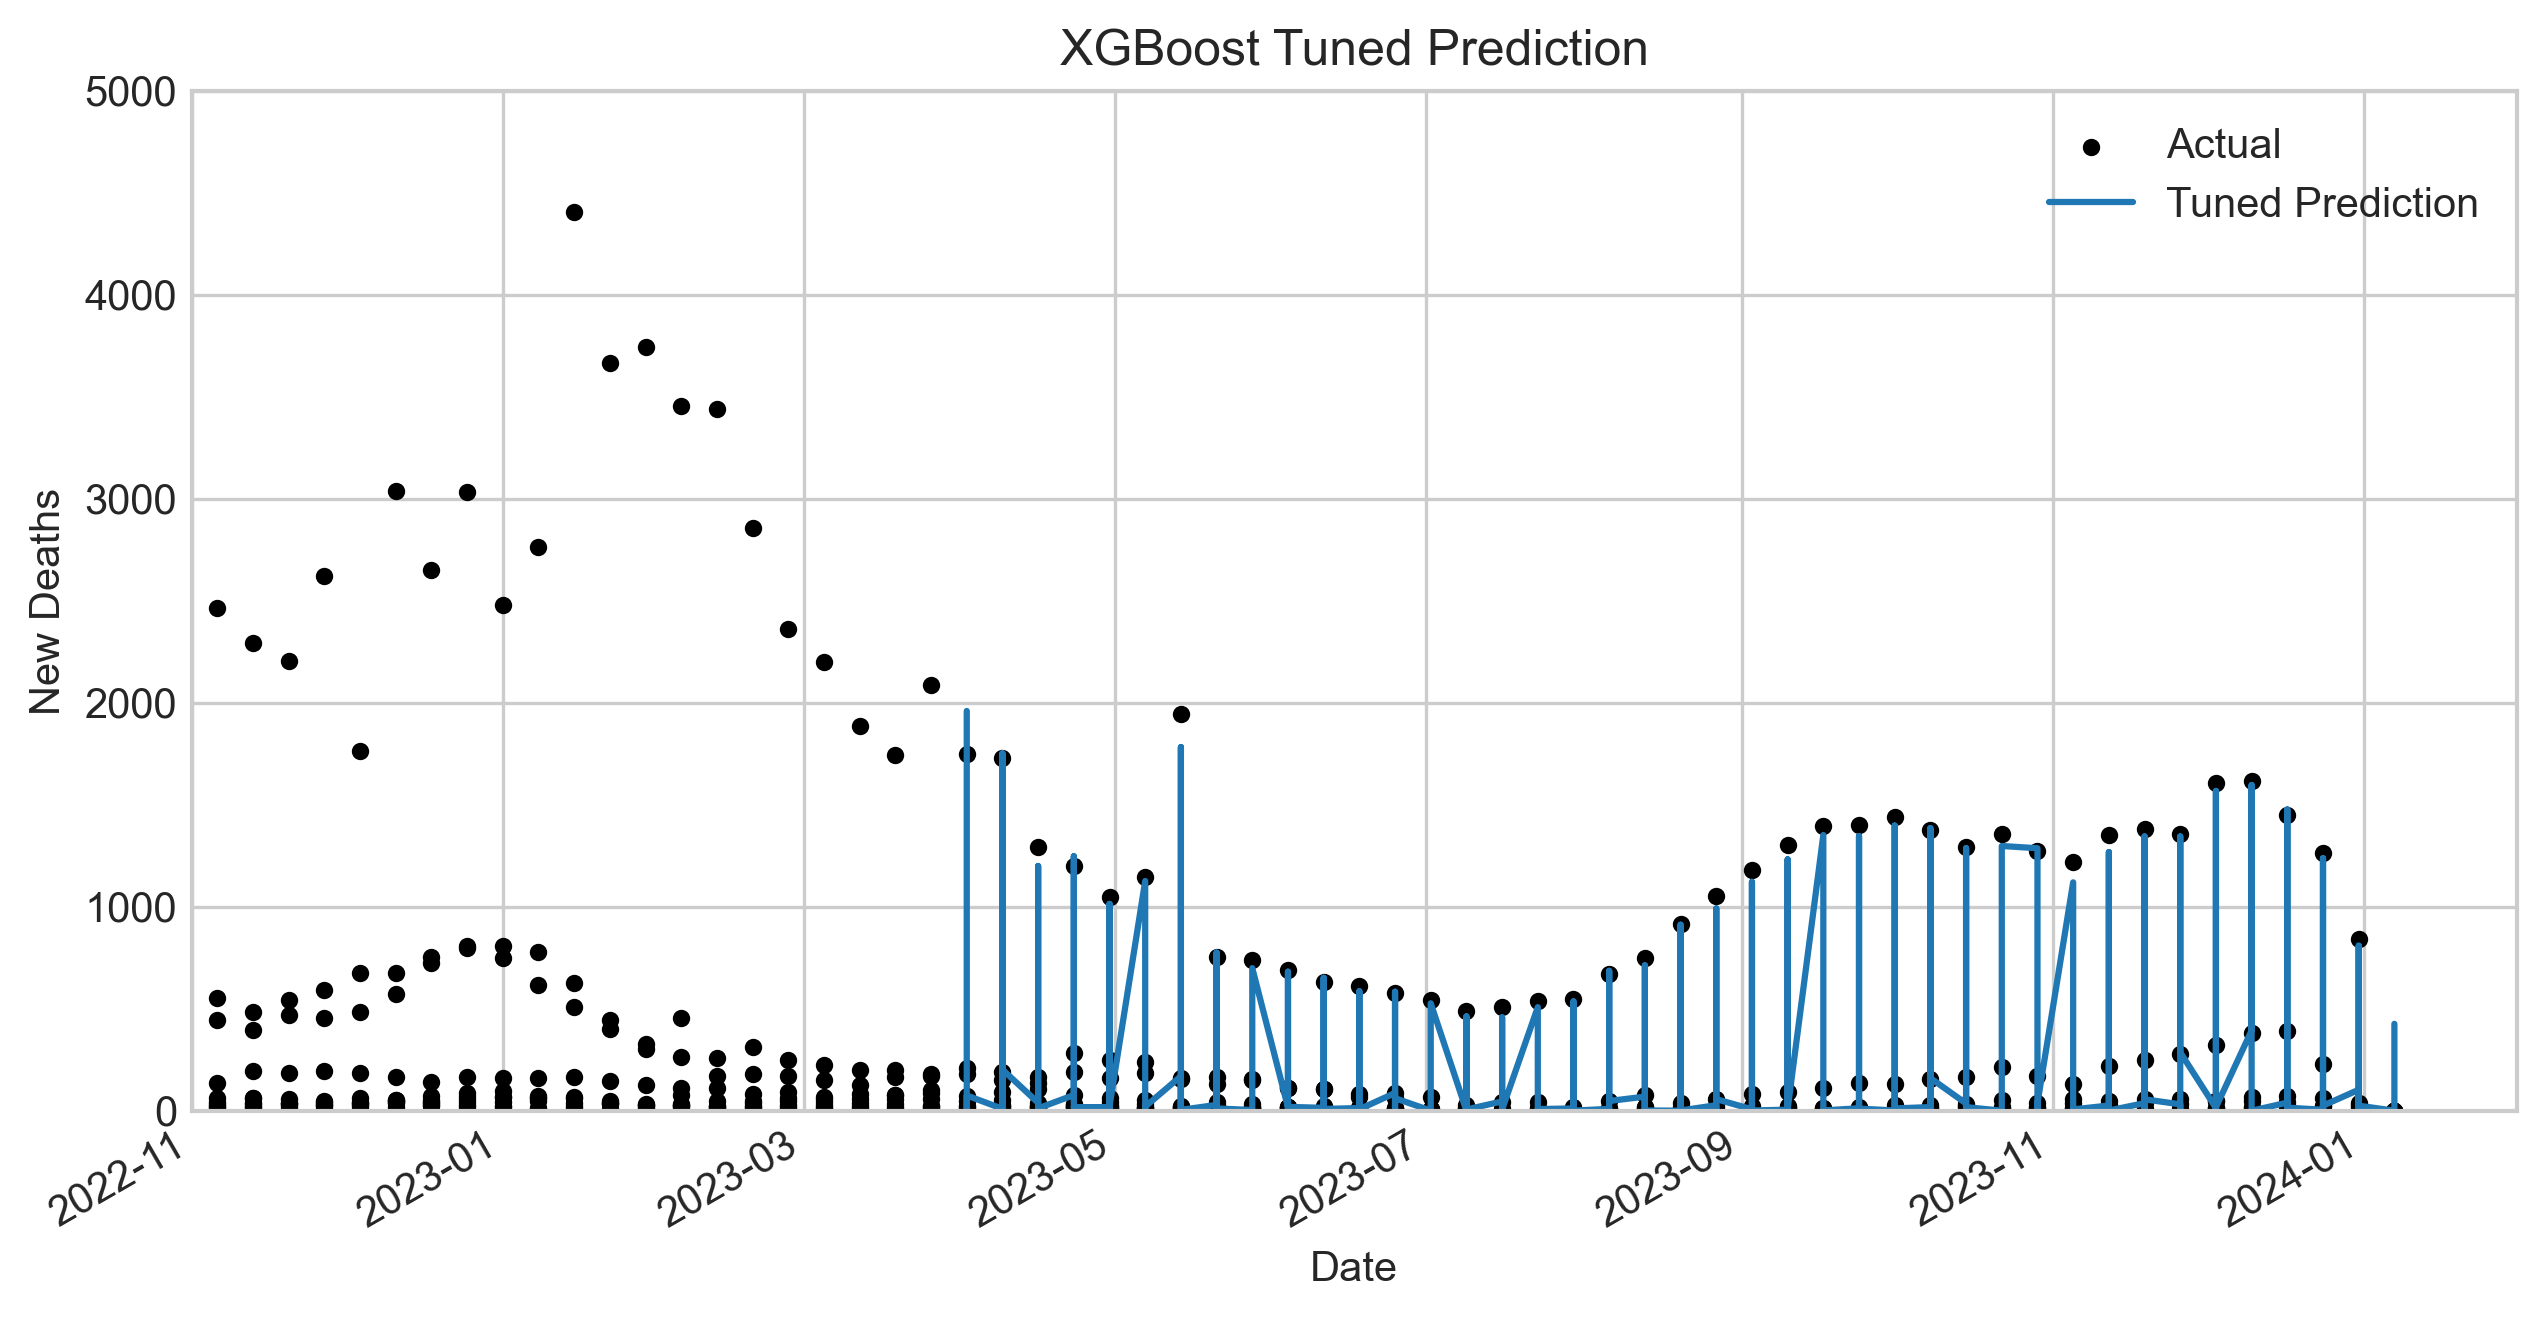

In [62]:
# tuned model 
model = xgb.XGBRegressor(max_depth=8,
                        learning_rate=.3,
                        reg_lambda=1,
                        n_estimators=1000,
                        gamma=10,
                        random_state=1,
                        early_stopping_rounds=100,
                        eval_metric='mae')
X_train_sub, X_test_sub, y_train_sub, y_test_sub = train_test_split(X_train, y_train, test_size = 0.2, random_state = 45)

model.fit(X_train, y_train,
        eval_set=[(X_train_sub,y_train_sub),(X_test_sub, y_test_sub)],
        verbose=True)

test['Tuned Prediction'] = model.predict(X_test)
deaths = pd.concat([test, train], sort=False)
# matplotlib line plot
# reset style
plt.style.use('seaborn-v0_8-whitegrid')
# increase resolution
plt.figure(dpi=300)
plt.scatter(deaths.index, deaths['new_deaths'], label='Actual', color = 'black', s=10)
plt.plot(deaths['Tuned Prediction'], label='Tuned Prediction')
plt.legend()
# make plot from november 2022
plt.xlim([datetime.date(2022, 11, 1), datetime.date(2024, 1, 31)])
plt.ylabel('New Deaths')
plt.xlabel('Date')
plt.title('XGBoost Tuned Prediction')
plt.gcf().autofmt_xdate()
fig = plt.gcf()
fig.set_size_inches(10, 5)
# limit max of y axis 
plt.ylim(0, 5000)
# change style of plot to ggplot
plt.show()

In [70]:
evaluation = pd.DataFrame(columns = ['Model', 'MAE', 'MASE'])
# calculate MAE
baseline_mae = mean_absolute_error(test['new_deaths'], test['Baseline Prediction'])
mase = MeanAbsoluteScaledError(sp=13)
baseline_mase = mase(test['new_deaths'], test['Baseline Prediction'], y_train = train['new_deaths'])
evaluation = evaluation.append({'Model': 'Baseline', 'MAE': baseline_mae, 'MASE': baseline_mase}, ignore_index=True)
# add tuned model
tuned_mae = mean_absolute_error(test['new_deaths'], test['Tuned Prediction'])
tuned_mase = mase(test['new_deaths'], test['Tuned Prediction'], y_train = train['new_deaths'])
evaluation = evaluation.append({'Model': 'Tuned', 'MAE': tuned_mae, 'MASE': tuned_mase}, ignore_index=True)
evaluation

,Model,MAE,MASE
0,Baseline,6.384383,0.003949
1,Tuned,7.161613,0.004430
